<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.21.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-51-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 8976ec9b8cf4827609e6d0ef306a95f1ea2d1ee0


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [16]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl, encoding='latin1')
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl, encoding='latin1')

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [17]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [19]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [20]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [21]:
def write_answer(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [24]:
cv_train = cross_val_score(knn, X_train, y_train, cv=skf)

In [25]:
knn_valid = knn.fit(X_train, y_train)
y_pred = knn_valid.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)

In [26]:
ans1 = np.round([np.mean(cv_train), cv_valid], 3)
ans1 = ' '.join(map(str, ans1))
print (ans1)

0.562 0.584


In [27]:
write_answer(ans1, 'answer1.txt')

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [28]:
''' ВАШ КОД ЗДЕСЬ '''

' ВАШ КОД ЗДЕСЬ '

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

In [31]:
cv_train = cross_val_score(forest, X_train, y_train, cv=skf)
cv_train

array([0.71354642, 0.71851174, 0.71262965])

In [32]:
valid_forest = forest.fit(X_train, y_train)
y_pred = valid_forest.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7350082958046931

In [33]:
ans2 = np.round([np.mean(cv_train), cv_valid], 3)
ans2 = ' '.join(map(str, ans2))
print (ans2)

0.715 0.735


In [34]:
write_answer(ans2, 'answer2.txt')

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [35]:
!cat answer2.txt

0.715 0.735

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [36]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [37]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [38]:
cv_train = cross_val_score(logit, X_train, y_train, cv=skf)
cv_train

array([0.76225266, 0.76059774, 0.76479561])

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [39]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=list(logit_c_values1), multi_class='multinomial', random_state=17, n_jobs=-1, cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 4.1 s, sys: 21.7 ms, total: 4.12 s
Wall time: 8.57 s


In [40]:
cv_train = cross_val_score(logit_grid_searcher1, X_train, y_train)

In [41]:
y_pred = logit_grid_searcher1.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7786205261910405

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [42]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1][0]
logit_mean_cv_scores1

array([0.32724505, 0.46940639, 0.55190259, 0.64231355, 0.71171994,
       0.74581431, 0.76073059, 0.76316591, 0.75677321, 0.74459665])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [43]:
print(np.max(logit_mean_cv_scores1))
print(logit_grid_searcher1.C_[0])

0.7631659056316591
4.641588833612772


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

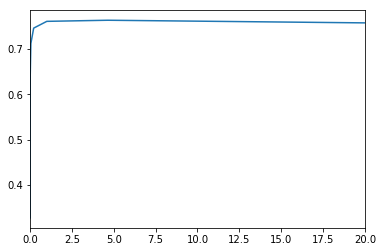

In [44]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.xlim(0, 20);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [45]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=list(logit_c_values2), 
                                            random_state=17, 
                                            cv=skf, 
                                            n_jobs=-1, 
                                            multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 3.99 s, sys: 34 ms, total: 4.02 s
Wall time: 24.2 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [46]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1][0]
logit_mean_cv_scores2

array([0.73302892, 0.75190259, 0.75951294, 0.76316591, 0.76347032,
       0.7652968 , 0.76499239, 0.76377473, 0.76468798, 0.76407915,
       0.76468798, 0.76407915, 0.76407915, 0.76347032, 0.76286149,
       0.76103501, 0.76012177, 0.75951294, 0.76012177, 0.76012177])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [47]:
print(np.max(logit_mean_cv_scores2))
print(logit_grid_searcher2.C_[6])

0.765296803652968
1.5526315789473686


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

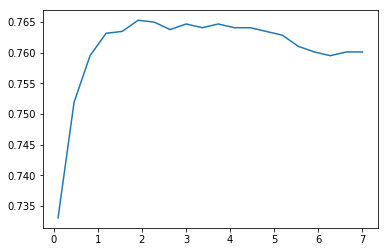

In [48]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [49]:
np.max(logit_mean_cv_scores2)

0.765296803652968

In [50]:
i = np.argmax(logit_mean_cv_scores2)

In [51]:
print(logit_grid_searcher2.scores_[1][0][i])
print(logit_grid_searcher2.Cs_[i])

0.765296803652968
1.9157894736842107


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [52]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7790945721735009

In [53]:
ans = np.round([np.max(logit_mean_cv_scores2), logit_cv_acc], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer3.txt')

0.765 0.779


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [54]:
from sklearn.svm import LinearSVC

In [55]:
svm = LinearSVC(C=1, random_state=17)

In [56]:
cv_train = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)

cv_train

array([0.75677321, 0.75327844, 0.75930445])

In [57]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
          verbose=0)

In [58]:
y_pred = svm.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7769613652524295

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [59]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.05 s, sys: 7.58 ms, total: 3.06 s
Wall time: 16.1 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [60]:
print('Best score is: {} with C: {}'.format(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_))

Best score is: 0.692237350132087 with C: {'C': 5555.555600000001}


In [61]:
svm_grid_searcher1.cv_results_ 

{'mean_fit_time': array([0.15191523, 4.19165945, 4.25014154, 3.84492588, 4.06116041,
        3.28579092, 3.54846311, 3.10631339, 2.34983269, 2.12316863]),
 'std_fit_time': array([0.01508777, 0.15860775, 0.04215793, 0.48202456, 0.11588546,
        0.01359106, 0.42771673, 0.70717029, 0.51127901, 0.55945867]),
 'mean_score_time': array([0.00163945, 0.00164787, 0.00158723, 0.00149639, 0.00155282,
        0.00156307, 0.00146715, 0.00111636, 0.00112724, 0.0010217 ]),
 'std_score_time': array([1.13465425e-05, 4.81461251e-05, 1.41471557e-04, 3.01837879e-05,
        6.60185595e-05, 7.28643481e-05, 3.27090441e-05, 3.20125301e-04,
        2.42892489e-04, 2.92531036e-04]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
      

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [62]:
from sklearn.model_selection import validation_curve

In [63]:
param_range1 = np.linspace(1e-4, 1e4, 10)

def plot_val_curves(model, X, y, param_range):
    train_scores, test_scores = validation_curve(
    svm, X_train, y_train, param_name="C", param_range=param_range,
    cv=skf, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(15,8))
    plt.title("Validation Curve with SVM")
    plt.xlabel(r"C")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show();

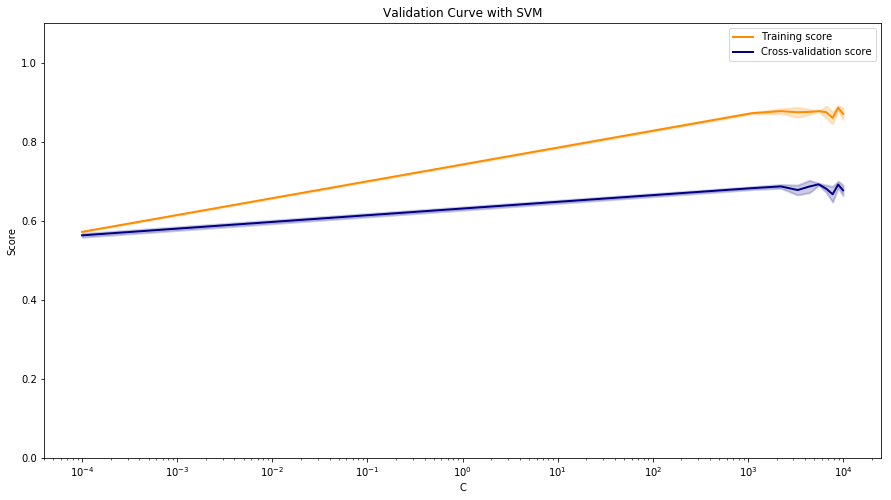

In [64]:
plot_val_curves(svm, X_train, y_train, param_range1)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [65]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.49 s, sys: 5.82 ms, total: 1.5 s
Wall time: 23.4 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [66]:
print ("Best score is: {} with C: {}".format(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_))

Best score is: 0.7649867913025807 with C: {'C': 0.24213793103448275}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

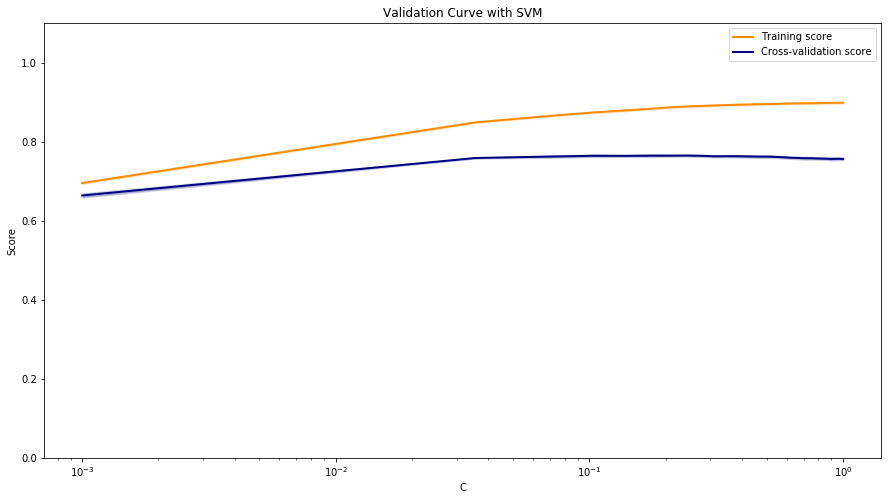

In [67]:
params2 = np.linspace(1e-3, 1, 30)
plot_val_curves(svm, X_train, y_train, params2)

In [68]:
#plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [69]:
svm = LinearSVC(random_state=17, **svm_grid_searcher2.best_params_)

In [70]:
svm.fit(X_train, y_train)

LinearSVC(C=0.24213793103448275, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

In [71]:
y_pred = svm.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7835980090068737

In [72]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.7835980090068737

In [73]:
np.max(svm_grid_searcher2.cv_results_['mean_test_score'])

0.7649867913025807

In [98]:
ans = np.round([np.max(svm_grid_searcher2.cv_results_['mean_test_score']), svm_cv_acc], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer4.txt')

0.765 0.784


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [75]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as f:
        X = pickle.load(f, encoding='latin1')
        
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f, encoding='latin1')

    X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                          y, 
                                                          test_size=test_size, 
                                                          random_state=random_state)
    
    cv_train = cross_val_score(estimator, X_train, y_train, cv=skf, n_jobs=-1)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_valid)
    cv_valid = accuracy_score(y_valid, y_pred)
    
    return [np.mean(cv_train), cv_valid]

**Убедитесь, что функция работает.**

In [76]:
model_assessment(svm_grid_searcher2.best_estimator_, 
               os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

[0.7666121756960682, 0.7781464802085802]

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [77]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [78]:
%%time
estimator = svm_grid_searcher2.best_estimator_

res_list = []

num_users = 10
print('window_size', 'session_length', 'mean_cv_score', 'test_score')
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        fname_X_cur = 'X_sparse_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        fname_y_cur = 'y_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        path_to_X_pkl = os.path.join(PATH_TO_DATA, fname_X_cur)
        path_to_y_pkl = os.path.join(PATH_TO_DATA, fname_y_cur)
        
        model_res = model_assessment(svm_grid_searcher2.best_estimator_, path_to_X_pkl, path_to_y_pkl,
                                     skf, random_state=17, test_size=0.3)

        res_list.append([window_size, session_length, model_res[0], model_res[1]])
        
        print('{:11} {:14} {:13} {:10}'.format(window_size, session_length,
                                               round(model_res[0], 3), round(model_res[1], 3)))
        
columns=['window_size', 'session_length', 'mean_cv_score', 'test_score']
win_size_sess_len_search_res = pd.DataFrame(res_list, columns=columns)

window_size session_length mean_cv_score test_score
         10             15          0.82       0.84
         10             10         0.767      0.778
          7             15         0.843      0.871
          7             10         0.799      0.813
          7              7         0.749      0.763
          5             15         0.869      0.878
          5             10         0.823      0.827
          5              7         0.775       0.78
          5              5         0.729      0.734
CPU times: user 15.1 s, sys: 21 ms, total: 15.1 s
Wall time: 25.2 s


In [79]:
win_size_sess_len_search_res

,window_size,session_length,mean_cv_score,test_score
0,10,15,0.820262,0.840009
1,10,10,0.766612,0.778146
2,7,15,0.843244,0.870914
3,7,10,0.798578,0.812510
4,7,7,0.749360,0.762900
5,5,15,0.869120,0.878378
6,5,10,0.822527,0.826577
7,5,7,0.774972,0.780346
8,5,5,0.729397,0.733523


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [95]:
win_size_sess_len_search_res.iloc[5,2]

0.8691197771408984

In [99]:
ans = np.round([win_size_sess_len_search_res.iloc[5,2], win_size_sess_len_search_res.iloc[5,3]], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer5.txt')

0.869 0.878


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

***Обратная линейная зависимость accuracy от ширины окна (чем меньше окно, тем лучше качество) и прямая зависимость от длины сессии (чем больше берем сайтов за сессию, тем лучше качество). Здесь все логично. В данном случае лучшее качество и на cv, и на валидации получается как раз на s15, w5.*** 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

In [102]:
%%time
estimator = svm_grid_searcher2.best_estimator_

res_list = []

num_users = 150
print('window_size', 'session_length', 'mean_cv_score', 'test_score')
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length:
        fname_X_cur = 'X_sparse_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        fname_y_cur = 'y_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        path_to_X_pkl = os.path.join(PATH_TO_DATA, fname_X_cur)
        path_to_y_pkl = os.path.join(PATH_TO_DATA, fname_y_cur)
        
        model_res = model_assessment(svm_grid_searcher2.best_estimator_, path_to_X_pkl, path_to_y_pkl,
                                     skf, random_state=17, test_size=0.3)

        res_list.append([window_size, session_length, model_res[0], model_res[1]])
        
        print('{:11} {:14} {:13} {:10}'.format(window_size, session_length,
                                               round(model_res[0], 3), round(model_res[1], 3)))
        
columns=['window_size', 'session_length', 'mean_cv_score', 'test_score']
win_size_sess_len_search_res = pd.DataFrame(res_list, columns=columns)

window_size session_length mean_cv_score test_score
          5              5          0.41      0.422
          7              7         0.437      0.457
         10             10         0.461      0.485
CPU times: user 9min 5s, sys: 492 ms, total: 9min 6s
Wall time: 15min 50s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

In [105]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_150users.pkl'), 'rb') as f:
    X_sparse_150users = pickle.load(f, encoding='latin1')
with open(os.path.join(PATH_TO_DATA, 
                       'y_150users.pkl'), 'rb') as f:
    y_150users = pickle.load(f, encoding='latin1')

In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_150users, y_150users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

In [107]:
svm = LinearSVC(random_state=17, **svm_grid_searcher2.best_params_)

In [109]:
cv_train = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
cv_train

array([0.46049838, 0.46161547, 0.45863484])

In [110]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.4841628959276018

In [111]:
ans = np.round([np.mean(cv_train), cv_valid], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer6.txt')

0.46 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [ ]:
class_distr = np.bincount(y_train_150.astype('int'))

class_prop = []
for user_id in np.unique(y_train_150):
    ''' ВАШ КОД ЗДЕСЬ '''

In [131]:
write_answer(round(num_better_than_default/150, 3), 'answer7.txt')

In [ ]:
#num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.